# Creating Contrast Curves

This notebook performs an analysis of contrast in PSF-Subtracted images. This process is done in a few simple steps:   

1) Fake planets are injected into the given dataset.  

2) pyKLIP is used to subtract the PSF of the star in the data.  

3) The fake planets are retrieved, and their post-klip flux values are measured.  

4) Contrast curves are created.

In [1]:
import os
import astropy.io.fits as fits
import numpy as np
import scipy
import scipy.ndimage as ndi
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pyklip.klip
import pyklip.instruments.Instrument as Instrument
import pyklip.parallelized as parallelized
import pyklip.rdi as rdi
import pyklip.fakes as fakes

### Loading the dataset

In [2]:
#Test that making thetas different. 

#Import the dataset to be used
filtername = "f300m"

# read in roll 1
with fits.open("old_simulated_data/test/TEST_NIRCam_target_Roll1_{0}.fits".format(filtername)) as hdulist:
    roll1_cube = hdulist[0].data

# read in roll 2
with fits.open("old_simulated_data/test/TEST_NIRCam_target_Roll2_{0}.fits".format(filtername)) as hdulist:
    roll2_cube = hdulist[0].data  

# combine the two rows
full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

# two rolls are offset 10 degrees
pas = np.append([0 for _ in range(roll1_cube.shape[0])], [70 for _ in range(roll2_cube.shape[0])])

# for each image, the (x,y) center where the star is is just the center of the image
centers = np.array([np.array(frame.shape)/2. for frame in full_seq])

# give it some names, just in case we want to refer to them
filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                      ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

#Define dataset
dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
dataset.flipx = False

### Specifying the parameters of the fake planet/s to be injected

In [3]:
#Specify the desired contrasts of the fake planets' flux
input_contrasts = [1e-4, 1e-5, 1e-6]
planet_seps = [30,40,50]
planet_fwhm = 3.5

#Loading in unocculted PSF
fake_fits_file = fits.open('old_simulated_data/test/TEST_NIRCam_unocculted_f356w.fits')



#Defining angle of injected fakes in CCW angle from +x axis to +y axis
thetas = [np.ones(12)*30.0, np.ones(12)*60.0, np.ones(12)*90.0, np.ones(12)*150.0, np.ones(12)*180.0, np.ones(12)*210.0]
#thetas = thetas+dataset.PAs
thetas

[array([30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.]),
 array([60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.]),
 array([90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90.]),
 array([150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
        150.]),
 array([180., 180., 180., 180., 180., 180., 180., 180., 180., 180., 180.,
        180.]),
 array([210., 210., 210., 210., 210., 210., 210., 210., 210., 210., 210.,
        210.])]

## Inject the fake planets

In [4]:
#Inject fakes
#Attempting to inject one fake at each theta in a spiral.

for input_contrast, planet_sep in zip(input_contrasts, planet_seps):
#Multiply unocculted psf by desired contrast level to simulate planet psf
    planet_fluxes = fake_fits_file[0].data*input_contrast


    for theta in thetas:
        fakes.inject_planet(frames = dataset.input, 
                            centers=dataset.centers, 
                            inputflux=planet_fluxes, 
                            astr_hdrs=dataset.wcs, 
                            radius=planet_sep,
                            pa = None,
                            thetas = theta)

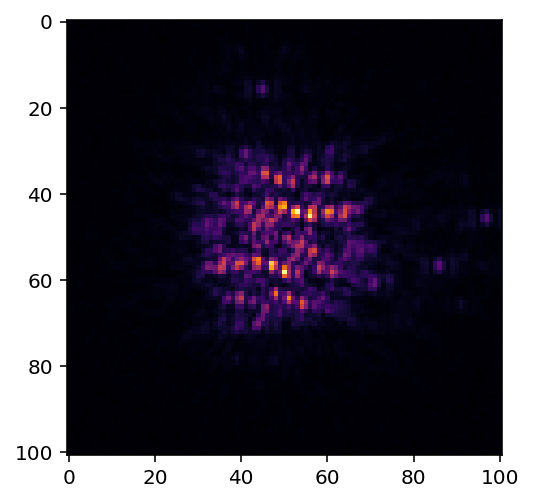

In [5]:
#Image with fakes injected before KLIP
plt.imshow(dataset.input[2], cmap = 'inferno')

## Run pyKLIP on injected fakes

In [6]:
#Set output directory
outputdir = 'contrastcurves'
fileprefix = 'TEST_FAKE_KLIP_ADI_A9K5S4M1'
numbasis = [1,5,10,20,50]


#Run KLIP on dataset with injected fakes
parallelized.klip_dataset(dataset, 
                          outputdir=outputdir, 
                          fileprefix=fileprefix, 
                          algo = 'klip', 
                          annuli=9, 
                          subsections=4, 
                          movement=1, 
                          numbasis=numbasis, 
                          mode="ADI")

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 36
27.78% done (9/36 completed)
55.56% done (19/36 completed)
83.33% done (29/36 completed)
Closing threadpool
Derotating Images...
Writing Images to directory /Users/jeaadams/JWST_PIPE/contrastcurves


/Users/jeaadams/Follete-group/Follette-group/wrapperUpdate/pyklip/pyklip/parallelized.py:1561: RuntimeWarning: Mean of empty slice
  KLmode_cube = np.nanmean(pixel_weights * dataset.output, axis=(1,2))


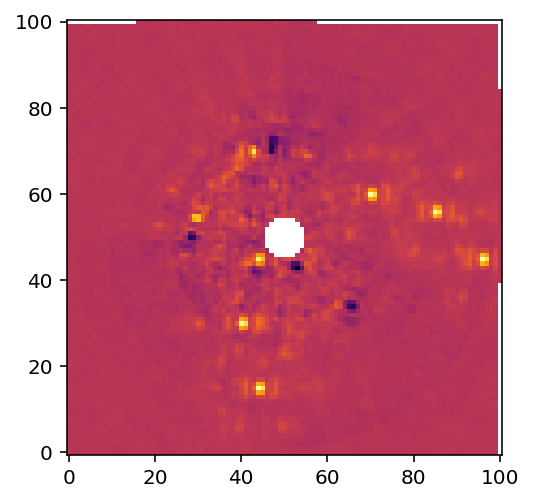

In [13]:
# Open the fits file created
with fits.open("contrastcurves/TEST_FAKE_KLIP_ADI_A9K5S4M1-KLmodes-all.fits") as hdulist:
    adi_cube = hdulist[0].data

#Plot the result of KLIP
plt.figure()
# plot the KL20 Cube (index of 3)
plt.imshow(adi_cube[2], interpolation='nearest', cmap = 'inferno')
plt.gca().invert_yaxis()

#Test that at the largest separation we see the psf move 8 pixels, open in ds9

## Read in the fits file created by KLIP

In [8]:
#reading in collapsed fits file at the first KL mode
with fits.open("contrastcurves/FAKE_KLIP_ADI_A9K5S4M1-KLmodes-all.fits") as hdulist:
    outputfile = hdulist[0].data[0]
    outputfile_centers = [hdulist[0].header['PSFCENTX'], hdulist[0].header['PSFCENTY']]

In [18]:
#Defining new thetas because only one KL mode used
thetas_retrieve = [30, 60, 90, 150, 180, 210]
#thetas_retieve = thetas+dataset.PAs KLIP accounts for this already. Don't need
thetas_retrieve
#new_planet_seps = 30

(101,)

In [10]:
#retrieving planet flux
for input_contrast, planet_sep in zip(input_contrasts, planet_seps):
    
#Create an empty list to store retrieved planet fluxes
    retrieved_planet_fluxes = []

    for theta in thetas_retrieve:
        fake_flux = fakes.retrieve_planet_flux(frames = outputfile, 
                                                centers=outputfile_centers,
                                                astr_hdrs=dataset.wcs[0], 
                                                sep=planet_sep,
                                                pa = None,
                                                thetas = theta,
                                                searchrad = 7)
        print(planet_sep)
        print(theta)
        retrieved_planet_fluxes.append(fake_flux)

#Get fakes retrieve working for one planet first,
#and then create for loop around 
#check that the flux makes sense

30
30
30
60
30
90
30
150
30
180
30
210
40
30
40
60
40
90
40
150
40
180
40
210
50
30
50
60


ValueError: operands could not be broadcast together with shapes (8,15) (15,15) 

In [ ]:
retrieved_planet_fluxes
#Check that new_planet_seps and thetas are what we think they should be
#Negative values might mean we missed values

## Compute throughput

In [ ]:
#Reminder to create unit test to make sure througput less than injected flux
throughput = np.array(retrieved_planet_fluxes)/np.array(input)

## Make Contrast Curves

In [ ]:
OWA = 65 #Setting this to be distance between star and outer edge of image
FWHM = 3.5

#Measuring the contrast in the image
contrast_seps, contrast = klip.meas_contrast(dat = outputfile, 
                                             IWA = dataset.IWA, 
                                             OWA = OWA, 
                                             resoltuion = FWHM, 
                                             center = outputfile_centers,
                                             low_pass_filter = False)
#do we need lowpass filter to be false?

In [ ]:
platescale =0.065 #milliarcseconds?
imsz = dataset.input.shape[1] #Setting the image size (101)
numann = 9
annspacing = (imsz/2.-dataset.IWA)/numann #Spacing between annuli? Why need?
zone_boundaries = np.arange(1,numann)*annspacing+dataset.IWA

plt.plot(contrast_seps*platescale, contrast)
plt.plot(contrast_seps*platescale, contrast, 'bo')
plt.yscale("log")
plt.ylim(1e-4, 1e-1)
plt.xlim(0,platescale*dataset_owa)
plt.xlabel("distance in arcseconds")
plt.ylabel("contrast")
if dataset.IWA > 0:
    plt.plot((dataset.IWA*platescale,dataset.IWA*platescale),(1e-5,1e-1), label='IWA')
for bd in zone_boundaries*platescale:
    if bd<dataset_owa*platescale:
        plt.plot((bd,bd),(0,1),'--',label='zone boundary')
plt.legend()
plt.savefig(outputdir+prefix+'_rawcontrast')
plt.clf() #clear figure

#create the throughput corrected contrast curves
corrected_contrast_curve = np.copy(contrast)
for i, sep in enumerate(contrast_seps):
    closest_throughput_index = np.argmin(np.abs(thrpt_seps - sep))
    print('for separation', sep, " closest throughput is at separation ", thrpt_seps[closest_throughput_index])
    corrected_contrast_curve[i] /= thrpt_list[closest_throughput_index]

 n
plt.plot(contrast_seps*platescale, corrected_contrast_curve, label='corrected 5$\sigma$ contrast')
plt.plot(contrast_seps*platescale, contrast, label='raw 5$\sigma$ contrast', color='gray')
plt.yscale("log")
plt.ylim(1e-3, 1e-1)
plt.xlabel("distance in arcseconds")
plt.ylabel("contrast")
if dataset.IWA > 0:
    plt.plot((dataset.IWA*platescale,dataset.IWA*platescale),(1e-5,1e-1), 'k--', label='IWA')
#for bd in zone_boundaries*platescale:
 #   plt.plot((bd,bd),(0,1),'--',label='zone boundary')
plt.legend()
plt.savefig(outputdir+prefix+'_contrastcurve')
